In [1]:
!pip install colour_demosaicing
!pip install scikit-video
!pip install progressbar

     |████████████████████████████████| 3.3 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 22.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.3 MB 3.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12074 sha256=0c514c42bb1f05f12a8b8b461fcaed8ea104d217e026ff1b59886e6811b0346f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/bc/13/93/a9bf6b3d3966e4af014b0dbef027fdea47393faf47e990349f
Successfully built progressbar
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import boto3
import sagemaker
import s3fs
fs = s3fs.S3FileSystem()
import seqIo
import matplotlib.pyplot as plt
import cv2

In [3]:
BUCKET = 'pose-estimates-for-bodhi' # the name of the bucket containing the pose jsons.

role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name

s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')
my_bucket = s3_resource.Bucket(BUCKET)

bucket_region = s3_client.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "You S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

In [6]:
# now let's extract a frame from a seq video.

# list all jsons and movies in the bucket using glob.
json_list = fs.glob('s3://{}/*.json'.format(BUCKET))
movie_list = fs.glob('s3://{}/*Top*.seq'.format(BUCKET))

# we'll take the first mouse as an example.
mouse_num = 20

mouse_name = json_list[mouse_num].replace('_pose_top_v1_5.json','')
json_file = 's3://' + json_list[mouse_num]

# given this mouse's json file, find the corresponding movie file.
movie_file = [i for i in movie_list if mouse_name in i][0]
movie_name = movie_file.replace(BUCKET+ '/','')
movie_file = 's3://' + movie_file

In [7]:
# now, load this mouse's json file.
with fs.open(json_file,'r') as file:
    data = json.load(file)

# and create a seqIo_reader to load the movie file!
# note: this takes a while to run, maybe 10 minutes per movie.
# While it's running, you'll get a status update every 1000 frames to tell you how far it's progressed.

# also note definition of s3_resource in second cell-- we called it s3_r in our call today.
sr = seqIo.seqIo_reader(movie_file,s3_resource)

building seek table for 50197 frames (this takes a while) ...
frame 1000
frame 2000
frame 3000
frame 4000
frame 5000
frame 6000
frame 7000
frame 8000
frame 9000
frame 10000
frame 11000
frame 12000
frame 13000
frame 14000
frame 15000
frame 16000
frame 17000
frame 18000
frame 19000
frame 20000
frame 21000
frame 22000
frame 23000
frame 24000
frame 25000
frame 26000
frame 27000
frame 28000
frame 29000
frame 30000
frame 31000
frame 32000
frame 33000
frame 34000
frame 35000
frame 36000
frame 37000
frame 38000
frame 39000
frame 40000
frame 41000
frame 42000
frame 43000
frame 44000
frame 45000
frame 46000
frame 47000
frame 48000
frame 49000
frame 50000


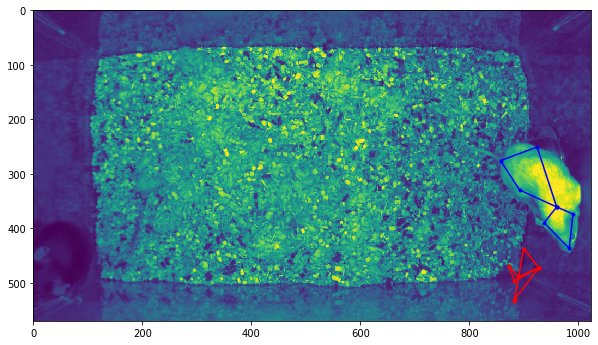

In [29]:
# You made it! now let's look at a sample frame to make sure things are working:

# the frame to load.
frame_number = 12269

# read the frame from the seq movie.
seq_img = sr.getFrame(frame_number)

# get the pose info from the json.
point_order = np.array([3, 2, 0, 1, 3, 4, 6, 5, 3])
black_mouse = np.array(data['keypoints'][frame_number][0])
white_mouse = np.array(data['keypoints'][frame_number][1])

# and plot.
plt.figure(figsize=(10,10))
plt.imshow(seq_img)
plt.plot(black_mouse[0][point_order], black_mouse[1][point_order],'r.-')
plt.plot(white_mouse[0][point_order], white_mouse[1][point_order],'b.-')
plt.show()

In [51]:
# Last part: let's save a frame of the movie to a folder in our bucket.

# the frame to load.
frame_number = 16281

# read the frame from the seq movie.
seq_img = sr.getFrame(frame_number)

#temporarily save the image to your jupyter directory.
cv2.imwrite('temp.jpg',seq_img)

# then upload it to the saved_frames folder inside your bucket.
# note, if you wanted you could modify this code to instead save images in a bucket in your own account!
# to do this, replace BUCKET in the text below with the name of an s3 bucket in your own account,
# and either create the "saved_frames" folder in that bucket or remove that part of img_name so it saves to
# the main bucket.

img_folder = "saved_frames"
img_name = "{}/{}_{}.jpg".format(img_folder, movie_name.replace('.seq',''), frame_number)
url = 's3://{}/{}'.format('savedframes-bodhi', img_name)

s3_resource.Bucket('savedframes-bodhi').Object(img_name).upload_file('temp.jpg')

print('Wrote frame to {}'.format(url))

Wrote frame to s3://savedframes-bodhi/saved_frames/Mouse_20170906_11-08-18_Top_J85_16281.jpg


In [194]:
# sanity check: check the contents of the s3 bucket to confirm there's an image there.

image_list = fs.glob('s3://{}/{}/*.jpg'.format('savedframes-bodhi',img_folder))
print(image_list)

['savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_12704.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_12705.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_13394.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_13395.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_13402.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_13404.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_13405.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_13406.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_13407.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_13410.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_13411.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_16-05-01_Top_J85_13412.jpg', 'savedframes-bodhi/saved_frames/Mouse351_20171115_1

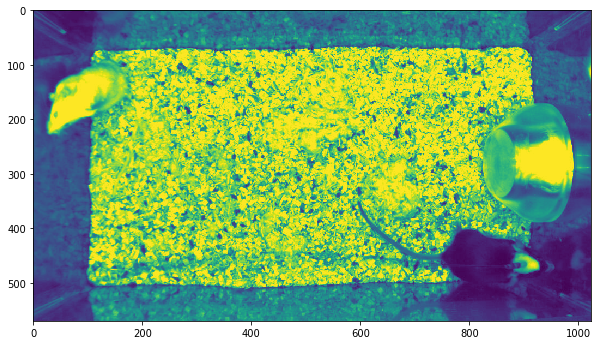

In [196]:
# sanity check number 2: re-load one of the images from the bucket.

import matplotlib.image as mpimg

read_image_number = 702
img_object = s3_resource.Bucket('savedframes-bodhi').Object('{}'.format(image_list[read_image_number].replace('savedframes-bodhi'+'/','')))

# copy the image to your Jupyter directory so we can load it.
img_object.download_file('temp.jpg')

# load the image.
img = mpimg.imread('temp.jpg')

plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)
plt.show()